In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np 
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt
from cobra.flux_analysis.loopless import loopless_solution


In [2]:
# Importing the model
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
model1.objective = "BIOMASS_RT"   


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [18]:
model1.reactions.get_by_id('EX_glc__D_e').bounds


(-1.0, 999999.0)

In [14]:
# Lab data
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1] 

# All fluxes for getting all rxn names
solution1 = model1.optimize()
all_fluxes = solution1.fluxes.to_frame(name='Flux')
all_fluxes

,Flux
ALCD25yi,0.0
MTHFCm,0.0
AMPN,0.0
DAGCPTer_RT,0.0
PYRt2,0.0
...,...
FOLt,0.0
NADtm,0.0
EX_pydxn_e,0.0
PYDXNtr,0.0


In [4]:
# Get all fluxes on different glucose uptake
all_fluxes_biomass_max = pd.DataFrame(columns=['Growth rate', 'Glucose uptake', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.objective = "BIOMASS_RT"  
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])    
    solution = model.optimize()
    solution = loopless_solution(model)
    
    all_fluxes_biomass_max.loc[i] = solution.fluxes[['BIOMASS_RT', 'EX_glc__D_e', *all_fluxes.index]].values

all_fluxes_biomass_max

,Growth rate,Glucose uptake,ALCD25yi,MTHFCm,AMPN,DAGCPTer_RT,PYRt2,NNDPRm,HMGCOASm,PDE4,...,EX_2hxmp_e,SALCNHe,EX_btn_e,BTNt2i,EX_fol_e,FOLt,NADtm,EX_pydxn_e,PYDXNtr,RIBFLVt2
0,0.033713,-0.476,0.0,0.0,0.0,0.0,0.0,0.0,-0.003255,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
1,0.081992,-1.114,0.0,0.0,0.0,0.0,0.0,0.0,-0.007917,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.122398,-1.648,0.0,0.0,0.0,0.0,0.0,0.0,-0.011818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.172112,-2.305,0.0,0.0,0.0,0.0,0.0,0.0,-0.016619,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.232267,-3.1,0.0,0.0,0.0,0.0,0.0,0.0,-0.022427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Get specific metabolites with their fluxes
exchange_fluxes_table = all_fluxes_biomass_max[['EX_glc__D_e', 'EX_o2_e', 'EX_nh4_e','EX_so4_e','EX_pi_e', 'EX_co2_e']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-Glucose exchange,O2 exchange,Ammonia exchange,Sulfate exchange,Phosphate exchange,CO2 exchange
0,-0.476,-1.149964,-0.222516,-0.003379,-0.008975,1.276335
1,-1.114,-2.534822,-0.541171,-0.008219,-0.021827,2.842163
2,-1.648,-3.69407,-0.807865,-0.012269,-0.032584,4.152871
3,-2.305,-5.120337,-1.135989,-0.017252,-0.045819,5.765485
4,-3.1,-6.846184,-1.533033,-0.023282,-0.061833,7.716821


In [6]:
intracellular_fluxes = all_fluxes_biomass_max[['ATPM', 'EX_glc__D_e', 'G6PDH2r', 'TKT1', 'TALA','TKT2', 'XPK', 'FBA', 'PYRDC','PDHm', 'ACITL']]

for i in range(len(intracellular_fluxes.columns)):
    if intracellular_fluxes.columns[i] != 'TKT1' and intracellular_fluxes.columns[i] != 'TKT2':
        intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

# Adding XPK and FPK together
intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] = intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] + all_fluxes_biomass_max['FPK']

# Change G6PDH2rp column name to oxpp 
intracellular_fluxes = intracellular_fluxes.rename(columns = {'Glucose 6-phosphate dehydrogenase': 'oxPPP', 'ATP maintenance requirement': 'NGAM', 'Xylulose-5-phosphate phosphoketolase': 'Phosphoketolase', 
                                                              'TKT1': 'Transketolase 1', 'TKT2': 'Transketolase 2'})
intracellular_fluxes

,NGAM,D-Glucose exchange,Glucose 6-phosphate dehydrogenase,Transketolase 1,Transaldolase,Transketolase 2,Phosphoketolase,Fructose-bisphosphate aldolase,Pyruvate decarboxylase,Pyruvate dehydrogenase,ATP-Citrate lyase
0,1.22,-0.476,0.0,-0.076355,-0.076355,0.0,0.181042,0.231238,0.015572,0.427713,0.0
1,1.22,-1.114,0.0,-0.1857,-0.1857,0.0,0.440304,0.518726,0.077178,0.950726,0.0
2,1.22,-1.648,0.0,-0.277214,-0.277214,0.0,0.65729,0.759369,0.120209,1.384278,0.0
3,1.22,-2.305,0.0,-0.389808,-0.389808,0.0,0.924256,1.055442,0.173151,1.917693,0.0
4,1.22,-3.1,0.0,-0.526052,-0.526052,0.0,1.247297,1.413703,0.237213,2.56315,0.0


Text(0, 0.5, 'Flux $(g/gDW/h)$')

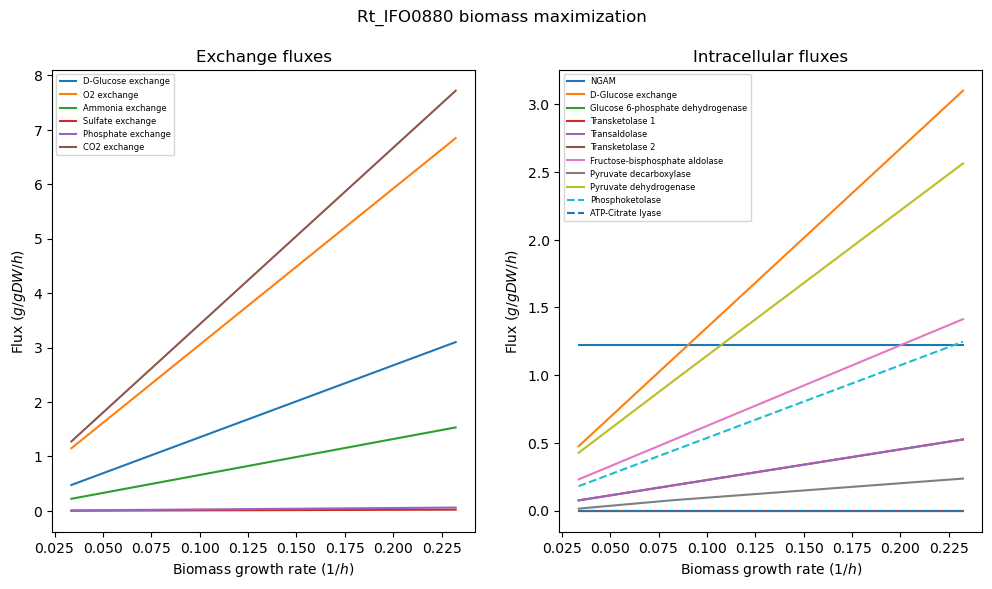

In [7]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('Rt_IFO0880 biomass maximization')

# Sample data

x1 = all_fluxes_biomass_max['BIOMASS_RT']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')

x2 = all_fluxes_biomass_max['BIOMASS_RT']
y2 = np.abs(intracellular_fluxes.drop(columns = ['Phosphoketolase','ATP-Citrate lyase']))
y3 = np.abs(intracellular_fluxes[['Phosphoketolase','ATP-Citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

COFACTOR balances

In [8]:
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1] # 
# Cofactor lists
nadphs = ['nadph_c', 'nadph_m', 'nadph_x', 'nadph_r']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_x', 'atp_r', 'atp_v', 'atp_n'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()

    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.objective = "BIOMASS_RT"  
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])    
    solution = model.optimize()
        
    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title):
    threshold = 0.05# threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.objective = "BIOMASS_RT" 
    solution = model.optimize()   
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    fig = plt.figure()
         
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    
    # plt.title(title)

    
    return pie_chart, fig


In [9]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get atp fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

SUM produced: 0.6029655918070933, SUM consumed: -0.6029655918070933
SUM produced: 3.9747355750384545, SUM consumed: -3.9747355750384545
SUM produced: 2.275229582611331, SUM consumed: -2.275229582611331
SUM produced: 13.546953061927669, SUM consumed: -13.546953061927669
SUM produced: 8.054412680127125, SUM consumed: -8.05441268012713
SUM produced: 47.5326351828699, SUM consumed: -47.53263518286992


,flux,reaction,percent
ATPS3m,37.076549,ATPS3m,0.780023
PGK,3.623681,PGK,0.076236
PYK,3.536733,PYK,0.074406
SUCOASm,2.046794,SUCOASm,0.043061
ACKr,1.247297,ACKr,0.026241
...,...,...,...
ACS,-1.270579,ACS,0.026731
PFK,-1.413703,PFK,0.029742
ADK1,-2.757378,ADK1,0.058010
HEX1,-3.100000,HEX1,0.065218


In [10]:
# import pickle

# with open("../cofactor_comparison/IFO0880_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)

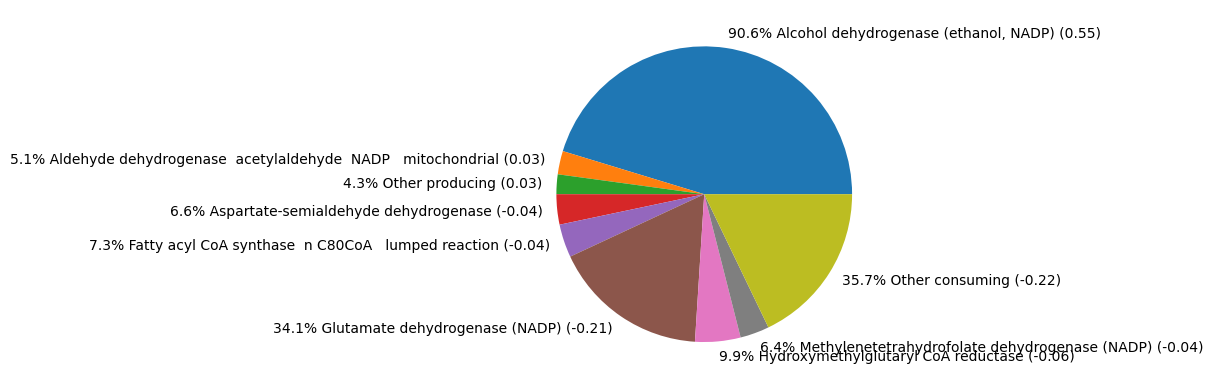

In [11]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title)
producing_nadph_fluxes_lowest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\IFO0880_biomass_max_NADPH.png")

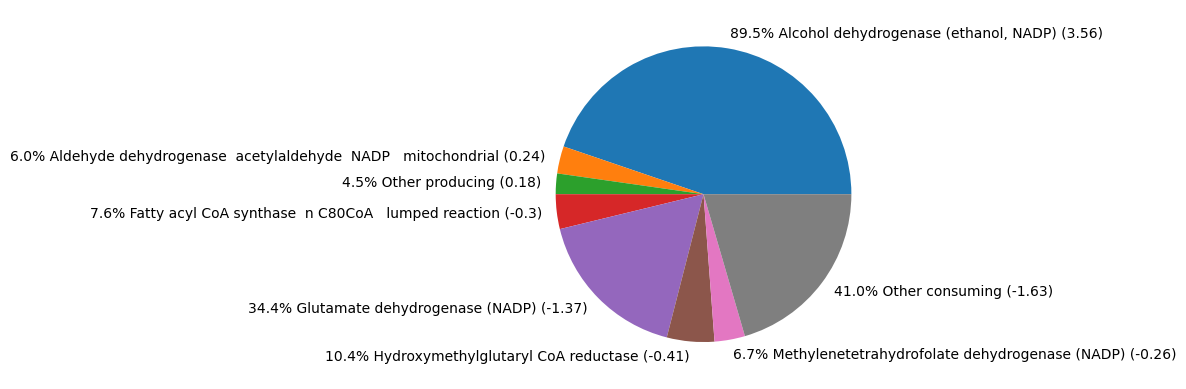

In [12]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title)
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\IFO0880_biomass_max_NADPH_max.png")

In [13]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

TypeError: cofactor_fluxes_pie_chart() takes 2 positional arguments but 3 were given

([<matplotlib.patches.Wedge at 0x1ab23fbb5f0>,
 [Text(1.0691276153906952, 0.2587781714306787, '15.1% 2-oxoglutarate dehydrogenase (2.05)'),
  Text(0.6879586516076118, 0.8583198085085982, '26.7% Glyceraldehyde-3-phosphate dehydrogenase (3.62)'),
  Text(-0.006781656703061688, 1.099979094861517, '16.7% Isocitrate dehydrogenase  NAD (2.26)'),
  Text(-0.5940542732783167, 0.9257966949604924, '19.3% Malate dehydrogenase  mitochondrial (2.61)'),
  Text(-0.8783372018528275, 0.6622112652630924, '3.3% Other producing (0.45)'),
  Text(-1.0517754844815463, 0.32213092096787094, '18.9% Pyruvate dehydrogenase (2.56)'),
  Text(-1.007665943341815, -0.4411454937195331, '26.3% Alcohol dehydrogenase (ethanol) (-3.56)'),
  Text(0.4068237659856705, -1.0220050995123442, '71.6% NADH dehydrogenase, mitochondrial (-9.7)'),
  Text(1.0993710961072698, -0.03719130333693755, '2.2% Other consuming (-0.29)')])

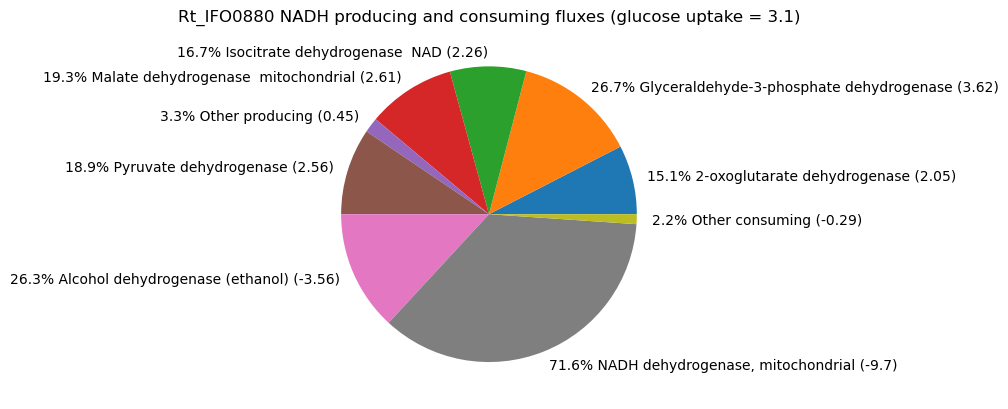

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1ab24833380>,
 [Text(1.0993144362043472, 0.038830018706130606, '2.2% Acetate kinase (0.18)'),
  Text(0.28227670880665445, 1.0631650199594056, '79.0% ATP synthase  mitochondrial (6.36)'),
  Text(-0.9142752456296012, 0.611637781067302, '0.0% Other producing (0.0)'),
  Text(-0.9773006032764661, 0.5048599120899336, '7.2% Phosphoglycerate kinase (0.58)'),
  Text(-1.0647558124924807, 0.2762156037653875, '7.0% Pyruvate kinase (0.57)'),
  Text(-1.0971678512988687, 0.07888413069955091, '4.6% Succinate  CoA ligase  ADP forming (0.37)'),
  Text(-1.0992885987347492, -0.03955473033395496, '2.3% Acetyl-CoA synthetase (-0.18)'),
  Text(-1.0876504270567058, -0.1643671150910841, '5.0% Adenylate kinase (-0.4)'),
  Text(-0.9827258256381595, -0.4942165027837477, '15.1% ATP maintenance requirement (-1.22)'),
  Text(0.056654658638830575, -1.0985400537324608, '58.5% Biomass (-4.71)'),
  Text(0.9610851243523114, -0.5350844641257138, '5.9% Hexokinase (D-glucose:ATP) (-0.48)'),


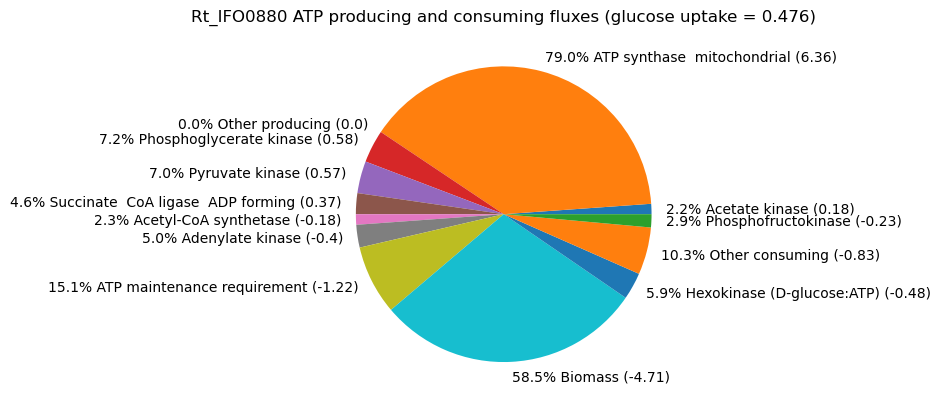

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1ab2521e7e0>,
 [Text(1.0990656773658822, 0.045328102059039664, '2.6% Acetate kinase (1.25)'),
  Text(0.286083720507979, 1.06214693186033, '78.0% ATP synthase  mitochondrial (37.08)'),
  Text(-0.9025017831823636, 0.6288803792078856, '0.0% Other producing (0.0)'),
  Text(-0.9711944450636443, 0.516508809099632, '7.6% Phosphoglycerate kinase (3.62)'),
  Text(-1.0652141815616873, 0.27444261221585925, '7.4% Pyruvate kinase (3.54)'),
  Text(-1.0974846268353382, 0.07434711736240199, '4.3% Succinate  CoA ligase  ADP forming (2.05)'),
  Text(-1.0990304808335225, -0.046173609332998085, '2.7% Acetyl-CoA synthetase (-1.27)'),
  Text(-1.08318022584536, -0.1916261942887636, '5.8% Adenylate kinase (-2.76)'),
  Text(-1.048722304915417, -0.33193602873580197, '2.6% ATP maintenance requirement (-1.22)'),
  Text(-0.16627104202297685, -1.0873609982818924, '68.3% Biomass (-32.45)'),
  Text(0.9389911371823801, -0.5729708930590982, '6.5% Hexokinase (D-glucose:ATP) (-3.1)'),
  T

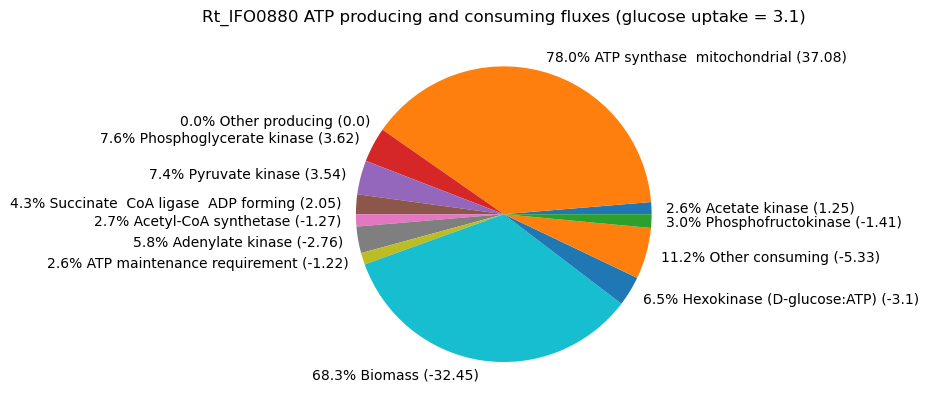

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [ ]:
# # Get all fluxes to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Simulated_fluxes\\Biomass_maximization\\all_fluxes_dif_glc_uptakes.xlsx') as excel_writer:
#     all_fluxes_dif_glucose_uptakes.to_excel(excel_writer, sheet_name='Glucose uptake range 0.49-3.1', index=True)

In [ ]:
# #  Get all flux values separately for dif growth rates, make them to a csv file
# for i in range(len(glucose_uptakes)):
#     all_fluxes_dif_glucose_uptakes.loc[i].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Simulated_fluxes\\Biomass_maximization\\fluxes_dif_glc_uptake_csv_files\\flux_values_specific_glucose_uptake_{glucose_uptakes[i]}.csv', index=True)